<a href="https://colab.research.google.com/github/nitinranjansharma/EVA5B2/blob/main/s10/S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
import albumentations as A
from PIL import Image
from albumentations.pytorch import ToTensor
from utility_fun import *

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from read_inputs import read_transform_inputs
trainset, trainloader, testset, testloader, classes = read_transform_inputs()

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 bird   car  bird horse


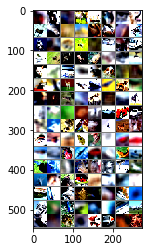

In [ ]:

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
from model import ResNet
from model import BasicBlock
from model import Bottleneck

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [ ]:
###Model Import
model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
show_model_summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
### Optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  pip install torch-lr-finder -v --global-option="amp"
 84%|████████▎ | 327/391 [17:17<03:19,  3.12s/it]Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


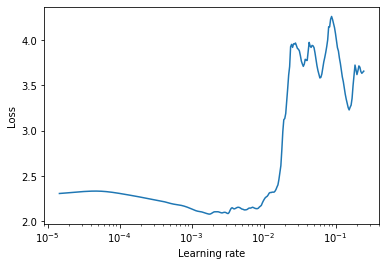

In [ ]:
##LR Finder
from lr_finder import LRFinder
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, val_loader=testloader, start_lr=1e-5, end_lr=2,num_iter=len(trainloader), step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [ ]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
lr = best_lr

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,
                              verbose=True, min_lr=1e-5)

In [ ]:
from train import *

In [ ]:
clf = training_class(model = model,trainloader = trainloader, testloader = testloader, device = device, epoch= 50, optimizer = optimizer, criterion = criterion ,l1 = 3e-6 , l2 = 1e-3,scheduler=scheduler)

In [ ]:
##TrainingLoop
train_acc,test_acc = clf.fit()

epoch [0] train accuracy 0.381 : test accuracy 0.445
epoch [1] train accuracy 0.433 : test accuracy 0.498
epoch [2] train accuracy 0.477 : test accuracy 0.535
epoch [3] train accuracy 0.499 : test accuracy 0.564
epoch [4] train accuracy 0.523 : test accuracy 0.592
epoch [5] train accuracy 0.510 : test accuracy 0.590
epoch [6] train accuracy 0.564 : test accuracy 0.638
epoch [7] train accuracy 0.568 : test accuracy 0.650
epoch [8] train accuracy 0.580 : test accuracy 0.661
epoch [9] train accuracy 0.592 : test accuracy 0.671
epoch [10] train accuracy 0.598 : test accuracy 0.683
epoch [11] train accuracy 0.605 : test accuracy 0.678
epoch [12] train accuracy 0.621 : test accuracy 0.706
epoch [13] train accuracy 0.622 : test accuracy 0.706
epoch [14] train accuracy 0.643 : test accuracy 0.719
epoch [15] train accuracy 0.631 : test accuracy 0.717
epoch [16] train accuracy 0.650 : test accuracy 0.729
epoch [17] train accuracy 0.661 : test accuracy 0.744
epoch [18] train accuracy 0.663 : test

In [ ]:
model_f  = clf.give_model()
torch.save(model_f, "model.sav")

In [ ]:
##loading model because crashed
model = torch.load("model.sav")

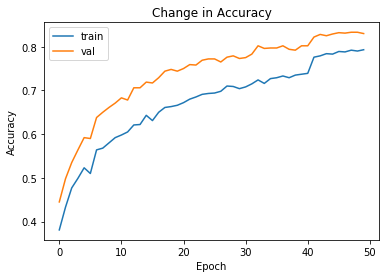

In [ ]:
plt_data = {
    "train": train_acc],
    "val": test_acc
}
plot_graph(plt_data, "Accuracy")

In [ ]:
##Test Loop
test_acc,correct_images,missclassified_images = clf.predict_method(testloader=testloader,miss_class=25,correct_class=25,remode = model)

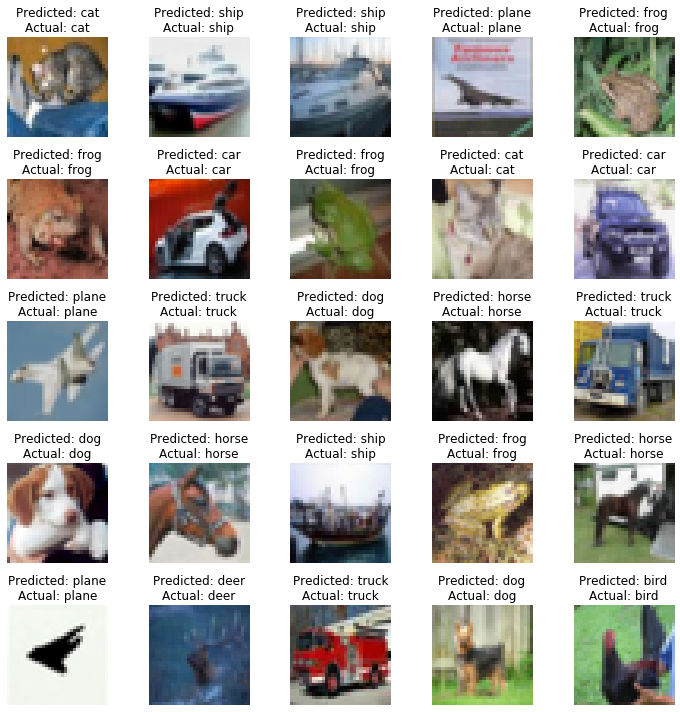

In [ ]:
plot_images(correct_images, classes, "correct_imgs.png")

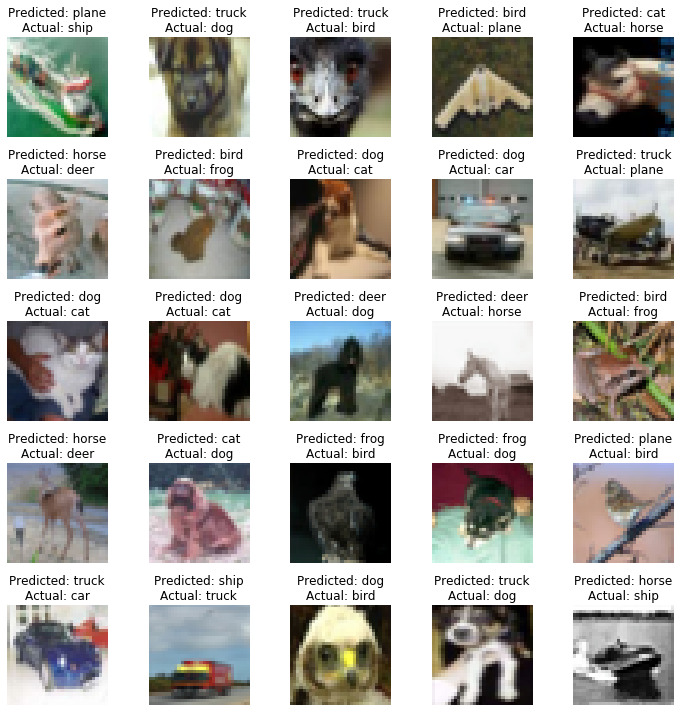

In [ ]:
plot_images(missclassified_images, classes, "Incorrect_imgs.png")

In [ ]:
from gradcam.visualize import VisualizeCam

In [ ]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = VisualizeCam(model,classes, target_layers)

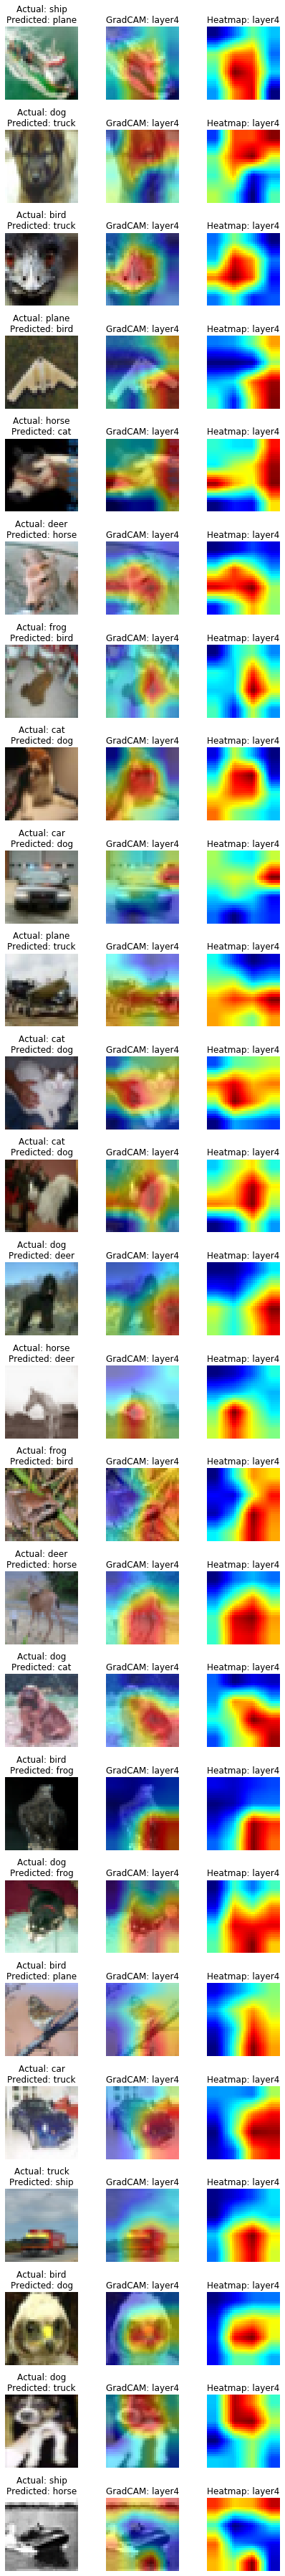

In [ ]:
##Gradcam for incorrect Images
num_img = 25
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(missclassified_images[i]["img"]))
  truth_inds.append(missclassified_images[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect",per_image=False)

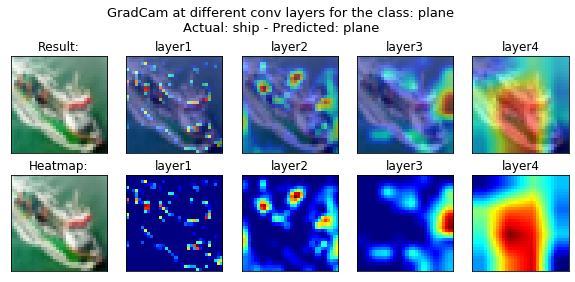

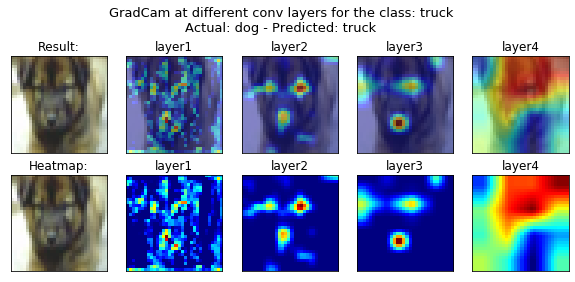

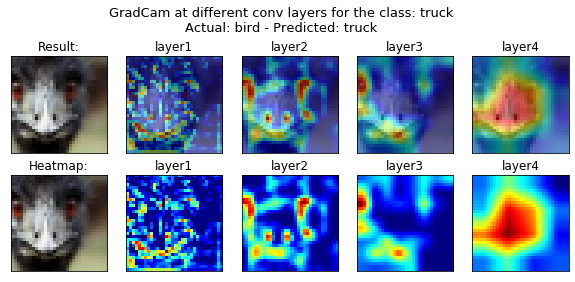

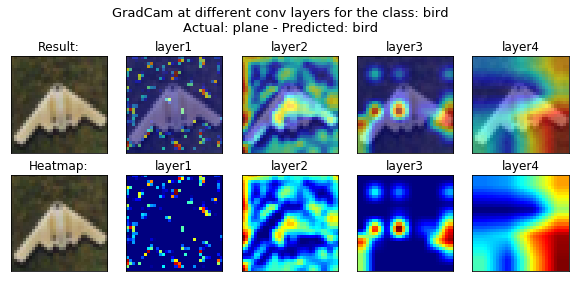

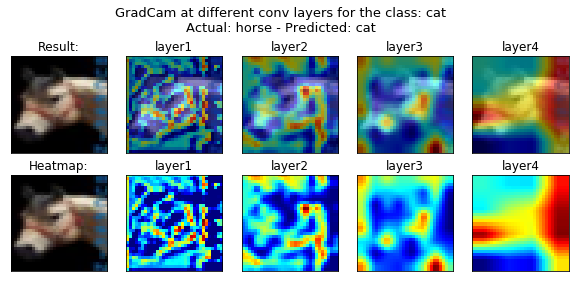

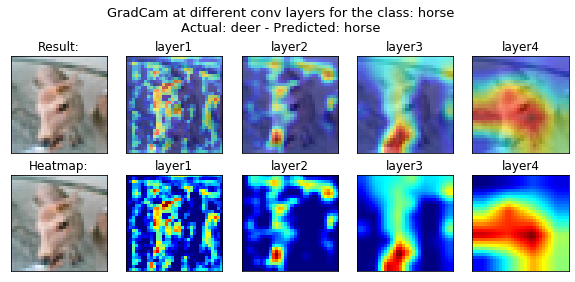

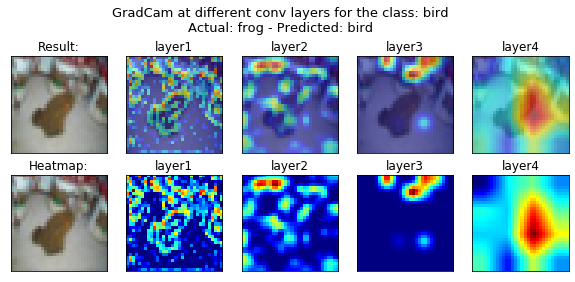

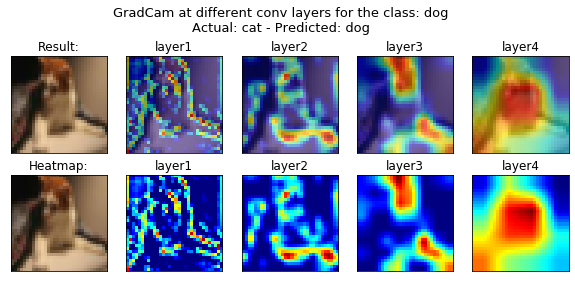

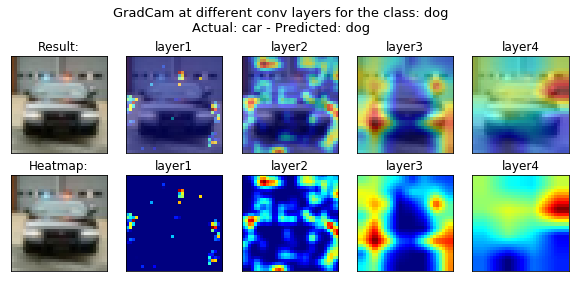

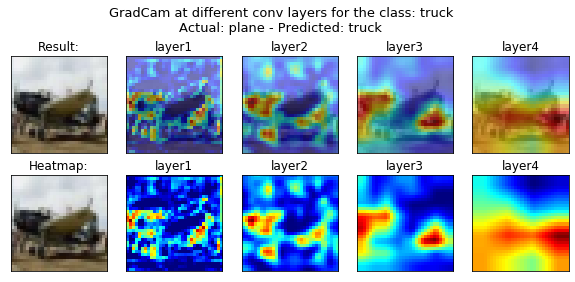

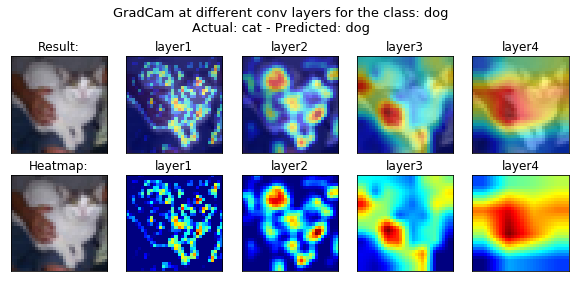

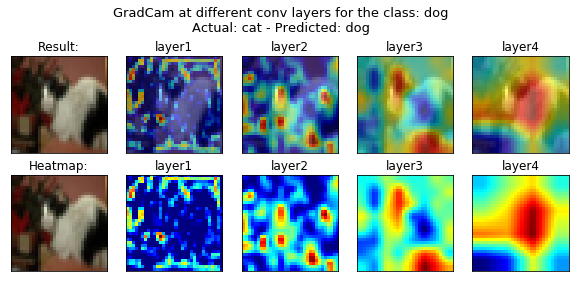

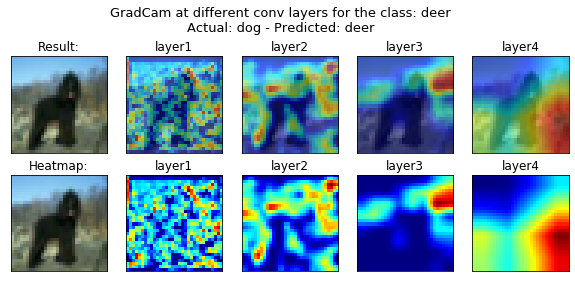

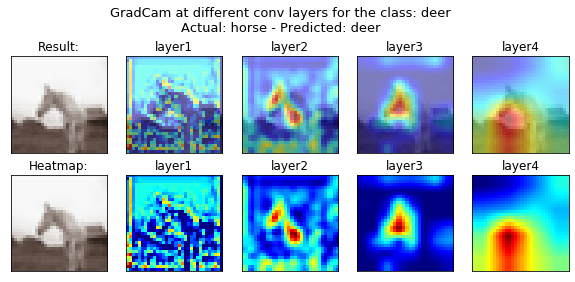

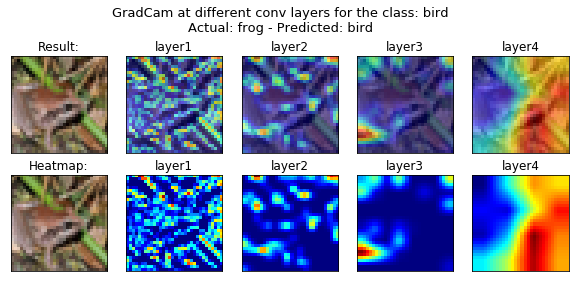

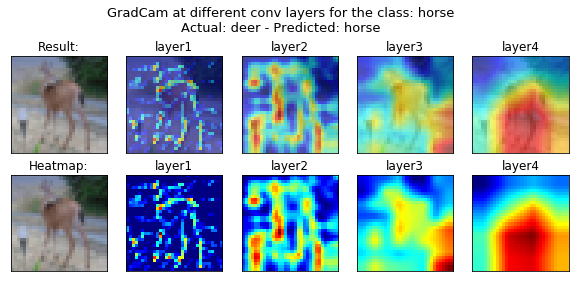

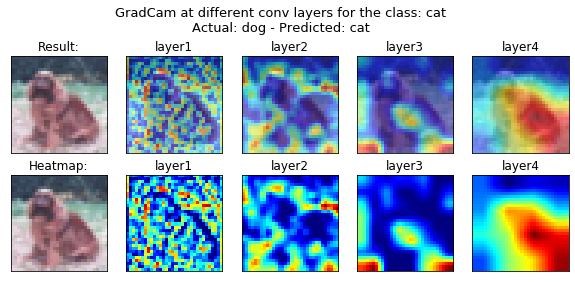

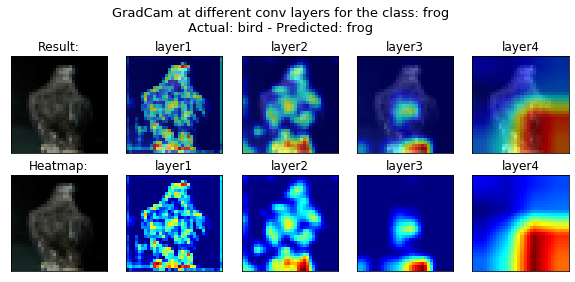

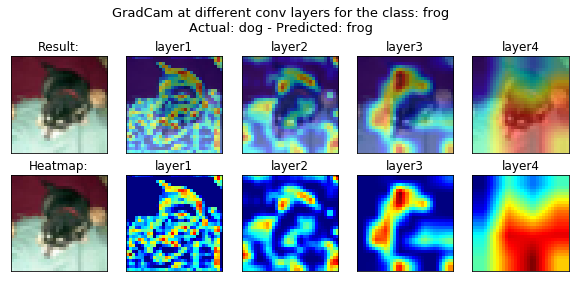

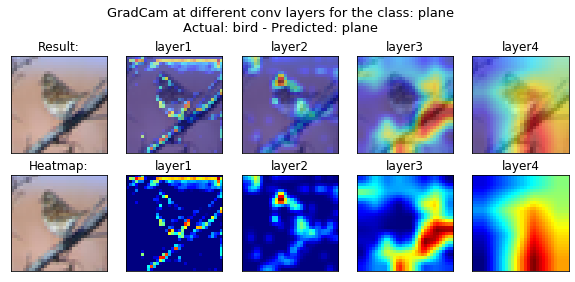

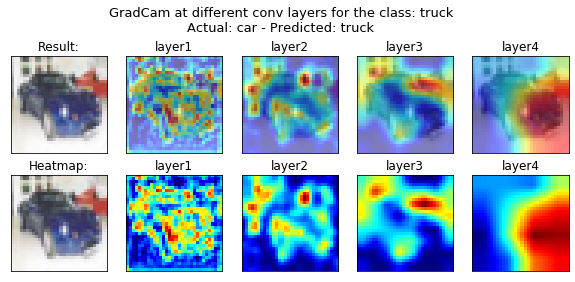

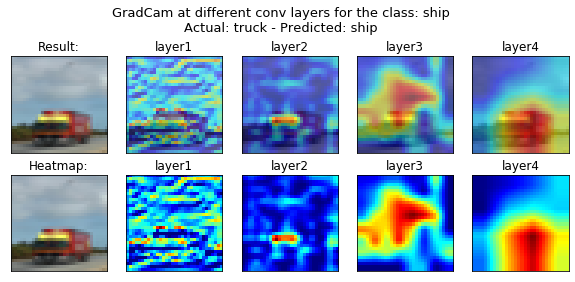

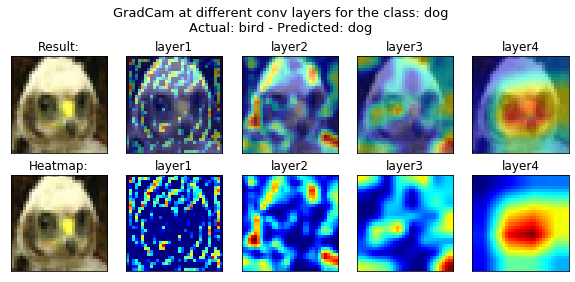

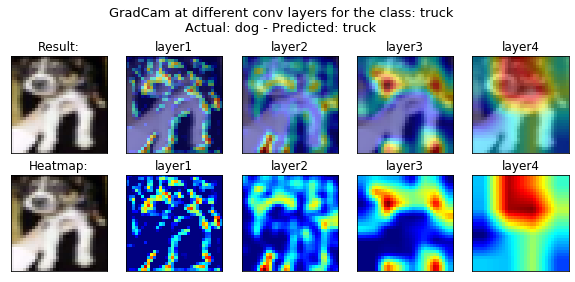

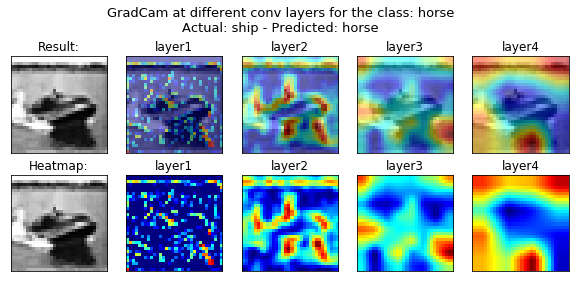

In [ ]:
##Detailed gradcam for incorrect images
num_img = 25
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(missclassified_images[i]["img"]))
  truth_inds.append(missclassified_images[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect")